In [13]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/kimhakhyun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# 판매 시작 시점 
with open('../data/preprocessed/first_sales_column_dict.pkl', 'rb') as f:
    first_sales_column_dict = pickle.load(f)

# 판매량 데이터 (아이템별 상이)
detrended_sales = pd.read_csv("../data/loess/detrended_sales.csv")
# 판매량 데이터의 주기, snr (아이템별 상이)
with open('../data/fourier/results.pkl', 'rb') as f:
    fourier_results = pickle.load(f)

# 판매 가격 데이터 (아이템별 상이)
log_differenced_sell_prices = pd.read_csv("../data/log_differencing/log_differenced_sell_prices.csv")
# 주말 여부 데이터 (1941일)
is_weekend = pd.read_csv("../data/preprocessed/is_weekend.csv")
# 이벤트 데이터 (1941일)
event_type_cultural = pd.read_csv("../data/preprocessed/event_type_cultural.csv")
event_type_national = pd.read_csv("../data/preprocessed/event_type_national.csv")
event_type_religious = pd.read_csv("../data/preprocessed/event_type_religious.csv")
event_type_sporting = pd.read_csv("../data/preprocessed/event_type_sporting.csv")

In [7]:
def sort_by_first_sale_day(state_item_id, first_sales_day):
    # 주 ID, 아이템 ID
    state_id, item_id = state_item_id

    # 필요한 데이터 필터링 (한 번씩만 필터링)
    sales_df = detrended_sales.query("state_id == @state_id and item_id == @item_id").iloc[0]
    price_df = log_differenced_sell_prices.query("state_id == @state_id and item_id == @item_id").iloc[0]
    
    # 각 데이터의 슬라이싱 시작 인덱스 계산
    start_col_sales = sales_df.index.get_loc(first_sales_day)
    start_col_price = price_df.index.get_loc(first_sales_day)

    # 각 데이터 슬라이싱
    sales_data = sales_df.iloc[start_col_sales:].values
    price_data = price_df.iloc[start_col_price:].values
    
    # 고정된 데이터 (weekend와 이벤트 데이터)
    start_col_weekend_event = is_weekend.columns.get_loc(first_sales_day)

    weekend_data = is_weekend.iloc[0, start_col_weekend_event:].values
    cultural_data = event_type_cultural.iloc[0, start_col_weekend_event:].values
    national_data = event_type_national.iloc[0, start_col_weekend_event:].values
    religious_data = event_type_religious.iloc[0, start_col_weekend_event:].values
    sporting_data = event_type_sporting.iloc[0, start_col_weekend_event:].values
    
    # 출력
    return {
        "sales": sales_data,
        "price": price_data,
        "weekend": weekend_data,
        "cultural": cultural_data,
        "national": national_data,
        "religious": religious_data,
        "sporting": sporting_data,
    }

In [8]:
def create_generator_for_each_item(num_kernels, look_back_window_size, look_forward_window_size):
    for state_item_id, first_sales_day in first_sales_column_dict.items(): # 아이템별로
        data = sort_by_first_sale_day(state_item_id, first_sales_day)

        kernel_sizes = [k for k in fourier_results[state_item_id]['selected_periods'][:num_kernels]]
        kernel_strengths = [k for k in fourier_results[state_item_id]['selected_strengths'][:num_kernels]]
        max_kernel_size = max(kernel_sizes)
        look_back_window_size = max(look_back_window_size, max_kernel_size)

        # 슬라이딩 윈도우 데이터 생성
        input_data = []
        output_data = []
        for i in range(len(data["sales"]) - look_back_window_size - look_forward_window_size): # 슬라이딩 윈도우
            ##### 슬라이딩 윈도우 간격
            input = {
                "sales": data["sales"][i:i+look_back_window_size],
                "price": data["price"][i:i+look_back_window_size],
                "weekend": data["weekend"][i:i+look_back_window_size],
                "cultural": data["cultural"][i:i+look_back_window_size],
                "national": data["national"][i:i+look_back_window_size],
                "religious": data["religious"][i:i+look_back_window_size],
                "sporting": data["sporting"][i:i+look_back_window_size],
            }
            output = data["sales"][i+look_back_window_size:i+look_back_window_size+look_forward_window_size]
            input_data.append(input)
            output_data.append(output)

        yield input_data, output_data, kernel_sizes, kernel_strengths  # 아이템별로 훈련/테스트 데이터 반환

In [17]:
class KernelWeights(tf.keras.layers.Layer):
    def __init__(self, kernel_strengths):
        super().__init__()
        self.kernel_strengths = self.add_weight(
            shape=(len(kernel_strengths),),
            initializer=tf.constant_initializer(kernel_strengths),
            trainable=True,
            name="kernel_weights"
        )

    def call(self, conv):
        # kernel_strengths를 Softmax로 정규화
        weights = tf.nn.softmax(self.kernel_strengths)

        # 각 Conv1D 출력에 가중치 적용
        weighted_conv = [
            strength * output for strength, output in zip(weights, conv)
        ]

        return weighted_conv

class AuxWeights(tf.keras.layers.Layer):
    def __init__(self, num_aux):
        super().__init__()
        self.aux_weights = self.add_weight(
            shape=(num_aux,),
            initializer='ones',
            trainable=True,
            name='aux_weights'
        )

    def call(self, aux):
        # look_back_window_size 축에서 비-제로 비율 계산
        non_zero_ratio = tf.reduce_mean(
            tf.cast(aux != 0, tf.float32),
            axis=1
        ) # (train_size, 6)
        
        # 기본 중요도와 비-제로 비율 결합
        weights = self.aux_weights * non_zero_ratio
        
        # Softmax로 정규화
        weights = tf.nn.softmax(weights, axis=-1) 

        # 가중치 적용
        weighted_aux = aux * tf.expand_dims(weights, axis=1) # (train_size, look_back_window_size, 6)
        
        return weighted_aux


class BuildModel(tf.keras.Model):
    def __init__(self, num_filters, kernel_sizes, kernel_strengths):
        super().__init__()
        self.kernel_weights_layer = KernelWeights(kernel_strengths)
        self.aux_weights_layer = AuxWeights(6)
        self.convs = [
            tf.keras.layers.Conv1D(
                filters=num_filters,
                kernel_size=int(k),
                padding='same'
            ) for k in kernel_sizes
        ]
    
    def call(self, sales_input, aux_input, look_forward_window_size):
        # Conv1D 레이어 처리
        weighted_conv_output = []
        sales_input = tf.expand_dims(sales_input, axis=-1)  # (train_size, look_back_window_size, 1)
        conv_outputs = [conv(sales_input) for conv in self.convs]

        # KernelWeights 적용
        weighted_conv_output = self.kernel_weights_layer(conv_outputs)
        weighted_conv_output = tf.concat(weighted_conv_output, axis=-1)  # (train_size, look_back_window_size, num_filters * len(kernel_sizes))
    
        # AuxWeights로 aux_input 가중치 적용
        weighted_aux_output = self.aux_weights_layer(aux_input)  # (train_size, look_back_window_size, 6)

        # Conv1D와 병합
        x = tf.concat([weighted_conv_output, weighted_aux_output], axis=-1)  # (train_size, look_back_window_size, combined_features)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)  # (train_size, combined_features)
        x = tf.keras.layers.Dense(128, activation='relu')(x)  # (train_size, 128)
        x = tf.keras.layers.Dense(64, activation='relu')(x) # (train_size, 64)
        x = tf.keras.layers.Dense(32, activation='relu')(x) # (train_size, 32)
        combined_output = tf.keras.layers.Dense(look_forward_window_size)(x) # (train_size, look_forward_window_size)

        return combined_output

Item 0: ('CA', 'FOODS_1_001')
Preparing Data
Preparing Loss and Optimizer
Building Model
Training


Epoch 1/1: 100%|██████████| 1528/1528 [00:44<00:00, 34.51batch/s, loss=0.328]


Epoch 1 Average Loss: 12.0608
Testing
Test Loss: 11.147305488586426


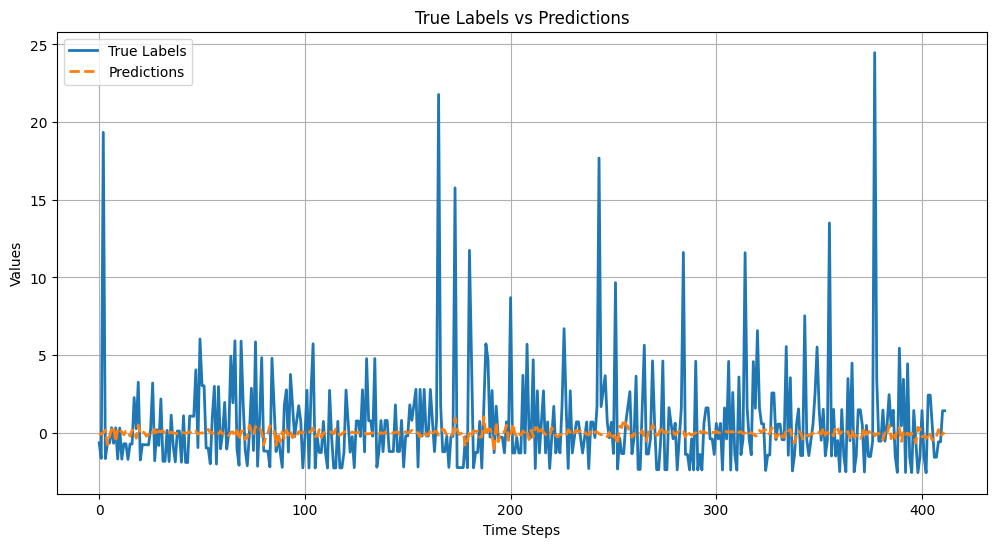

Item 1: ('CA', 'FOODS_1_001')
Preparing Data
Preparing Loss and Optimizer
Building Model
Training


Epoch 1/1:  48%|████▊     | 732/1528 [00:22<00:24, 31.97batch/s, loss=0.275]   

In [18]:
# 파라미터 설정
test_size = 0.2

n_epochs = 100
learning_rate = 0.001
batch_size = 1

num_kernels = 10 # 상위 몇 개 커널 사용할지
look_back_window_size = 30
look_forward_window_size = 1

for state_item_id, first_sales_day in first_sales_column_dict.items(): # 아이템별로
    # 제너레이터에서 해당 아이템의 데이터만 가져오기
    item_windows_generator = create_generator_for_each_item(num_kernels=num_kernels, 
                                                            look_back_window_size=look_back_window_size, 
                                                            look_forward_window_size=look_forward_window_size)

    for item_idx, (input_data, output_data, kernel_sizes, kernel_strengths) in enumerate(item_windows_generator): # 윈도우별로 (배치별로)
        print(f"\033[93mItem {item_idx}: {state_item_id}\033[0m")

        print(f"\033[92mPreparing Data\033[0m")
        split_index = int(len(input_data) * (1 - test_size))
        train_data = [(input_data[i], output_data[i]) for i in range(split_index)]
        test_data = [(input_data[i], output_data[i]) for i in range(split_index - look_back_window_size, len(input_data))]

        X_sales_train = np.array([x['sales'] for x, _ in train_data]).astype(np.float32)  # (train_size, look_back_window_size)
        X_aux_train = np.array([
            np.column_stack([
                x['price'],
                x['weekend'],
                x['cultural'],
                x['national'],
                x['religious'],
                x['sporting']
            ]) for x, _ in train_data
        ]).astype(np.float32)  # (train_size, look_back_window_size, 6)
        y_train = np.array([y for _, y in train_data]).astype(np.float32)  # (train_size, look_forward_window_size)

        X_sales_test = np.array([x['sales'] for x, _ in test_data]).astype(np.float32)  # (test_size, look_back_window_size)
        X_aux_test = np.array([
            np.column_stack([
                x['price'],
                x['weekend'],
                x['cultural'],
                x['national'],
                x['religious'],
                x['sporting']
            ]) for x, _ in test_data
        ]).astype(np.float32)  # (test_size, look_back_window_size, 6)

        y_test = np.array([y for _, y in test_data]).astype(np.float32)  # (test_size, look_forward_window_size)

        print(f"\033[92mPreparing Loss and Optimizer\033[0m")
        loss = loss = tf.keras.losses.MeanSquaredError()
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        print(f"\033[92mBuilding Model\033[0m")
        model = BuildModel(
            num_filters=32,
            kernel_sizes=kernel_sizes,
            kernel_strengths=kernel_strengths
        )

        print(f"\033[92mTraining\033[0m")
        train_dataset = tf.data.Dataset.from_tensor_slices(({"sales": X_sales_train, "aux": X_aux_train}, y_train))
        train_dataset = train_dataset.batch(batch_size)

        for epoch in range(n_epochs):
            epoch_loss = 0.0
            with tqdm(total=len(train_dataset), desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch") as pbar:
                for step, (inputs, labels) in enumerate(train_dataset):
                    with tf.GradientTape() as tape:
                        predictions = model(inputs["sales"], inputs["aux"], look_forward_window_size=look_forward_window_size)
                        train_loss = loss(labels, predictions)
                    gradients = tape.gradient(train_loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    
                    epoch_loss += train_loss.numpy()
                    pbar.set_postfix({"loss": train_loss.numpy()})
                    pbar.update(1) 
            print(f"Epoch {epoch+1} Average Loss: {epoch_loss / len(train_dataset):.4f}")

        print(f"\033[92mTesting\033[0m")
        test_dataset = tf.data.Dataset.from_tensor_slices(({"sales": X_sales_test, "aux": X_aux_test}, y_test))
        test_dataset = test_dataset.batch(batch_size)
        test_loss = 0.0

        predictions_list = []
        for step, (inputs, labels) in enumerate(test_dataset):
            predictions = model(inputs["sales"], inputs["aux"], look_forward_window_size=look_forward_window_size)
            test_loss += loss(labels, predictions).numpy()
            predictions_list.append((labels.numpy(), predictions.numpy()))

        test_loss /= len(test_dataset)
        print(f"Test Loss: {test_loss}")

        # 예측과 실제값 시각화 및 저장
        labels = np.concatenate([item[0] for item in predictions_list])
        predictions = np.concatenate([item[1] for item in predictions_list])

        # 그래프 그리기
        plt.figure(figsize=(12, 6))
        plt.plot(labels, label='True Labels', linewidth=2)
        plt.plot(predictions, label='Predictions', linewidth=2, linestyle='--')
        plt.title("True Labels vs Predictions")
        plt.xlabel("Time Steps")
        plt.ylabel("Values")
        plt.legend()
        plt.grid(True)

        # 그림 저장
        plt.savefig("true_labels_vs_predictions.png")
        plt.show()

        break
    break
    #     # print(f"\033[92mAnalyzing\033[0m")
    #     # # 모델 해석 단계
    #     # analyzer = AnalyzeModel(model, X_sales_test, X_aux_test)
    #     # analyzer.pdp(feature_index=0)  # 예시: 첫 번째 보조 특성에 대한 PDP
    #     # analyzer.ice(feature_index=0)  # 예시: 첫 번째 보조 특성에 대한 ICE
    #     # analyzer.feature_weights()  # 모델의 학습된 가중치 출력

    # # # 모델 저장
    # # model.save(f"model_{state_item_id}.h5")

    # # # 모델 가중치 초기화
    # # model.reset_states()

    # break

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap


class AnalyzeModel:
    def __init__(self, model, sales_input, aux_input):
        """
        AnalyzeModel 클래스 초기화

        :param model: 분석할 학습된 모델
        :param sales_input: 시계열 데이터 입력 (e.g., sales input)
        :param aux_input: 보조 특성 입력
        """
        self.model = model
        self.sales_input = sales_input
        self.aux_input = aux_input

    def pdp(self, feature_index):
        """
        Partial Dependence Plot (PDP):
        특정 입력 특성이 모델 출력에 미치는 평균적인 영향을 분석
        :param feature_index: 보조 특성(aux_input)에서 분석할 특성의 인덱스
        """
        feature_values = np.linspace(
            np.min(self.aux_input[:, :, feature_index]), 
            np.max(self.aux_input[:, :, feature_index]), 
            50
        )
        pdp_values = []
        data_copy = self.aux_input.copy()

        for val in feature_values:
            data_copy[:, :, feature_index] = val
            preds = self.model([self.sales_input, data_copy], training=False)
            pdp_values.append(np.mean(preds))

        plt.plot(feature_values, pdp_values)
        plt.xlabel(f"Feature {feature_index}")
        plt.ylabel("Predicted Output")
        plt.title(f"PDP for Feature {feature_index}")
        plt.show()

        # 모델 개선 방안:
        # PDP를 통해 중요도가 낮은 특성을 제거하거나, 중요한 특성을 강조하는 추가적인 전처리 단계를 설계할 수 있음.

    def ice(self, feature_index):
        """
        Individual Conditional Expectation (ICE):
        특정 입력 특성이 각 샘플별로 모델 출력에 미치는 영향을 시각화
        :param feature_index: 보조 특성(aux_input)에서 분석할 특성의 인덱스
        """
        feature_values = np.linspace(
            np.min(self.aux_input[:, :, feature_index]), 
            np.max(self.aux_input[:, :, feature_index]), 
            50
        )
        data_copy = self.aux_input.copy()

        for sample_idx in range(len(data_copy)):
            ice_values = []
            for val in feature_values:
                data_copy[sample_idx, :, feature_index] = val
                preds = self.model([self.sales_input, data_copy], training=False)
                ice_values.append(preds[sample_idx])

            plt.plot(feature_values, ice_values, alpha=0.5)

        plt.xlabel(f"Feature {feature_index}")
        plt.ylabel("Predicted Output")
        plt.title(f"ICE for Feature {feature_index}")
        plt.show()

        # 모델 개선 방안:
        # ICE를 통해 각 샘플별로 중요한 입력 값을 찾아내고, 입력 데이터를 샘플별로 정규화하거나 특성 공학을 적용할 수 있음.

    def lime(self, instance_index):
        """
        LIME (Local Interpretable Model-agnostic Explanations):
        개별 예측에 대한 해석을 제공하기 위해 모델을 선형 근사
        :param instance_index: 설명할 샘플의 인덱스
        """

        data = self.aux_input.reshape(self.aux_input.shape[0], -1)  # Flatten aux_input
        explainer = LimeTabularExplainer(data, mode="regression")
        instance = data[instance_index]
        prediction_fn = lambda x: self.model([self.sales_input[:len(x)], x.reshape(-1, *self.aux_input.shape[1:])])

        exp = explainer.explain_instance(instance, prediction_fn)
        exp.show_in_notebook()

        # 모델 개선 방안:
        # LIME 결과를 바탕으로 특정 입력 값의 비선형적 영향을 보정하는 특성 변환을 설계할 수 있음.

    def temporal_lime(self, instance_index):
        """
        Temporal LIME:
        시간 축 데이터를 고려한 LIME 해석
        :param instance_index: 설명할 샘플의 인덱스
        """
        # 시간 축이 있는 데이터에 대해, LIME을 변형하여 적용 가능
        # 구체적인 구현은 데이터 구조와 시간적 특성을 반영해야 함.
        pass

    def shap_analysis(self):
        """
        SHAP (SHapley Additive exPlanations):
        게임 이론에 기반한 Shapley 값을 사용하여 모델 예측 해석
        """
        explainer = shap.KernelExplainer(self.model, [self.sales_input, self.aux_input])
        shap_values = explainer.shap_values([self.sales_input, self.aux_input])

        shap.summary_plot(shap_values, [self.sales_input, self.aux_input])

        # 모델 개선 방안:
        # SHAP 분석 결과를 통해 출력에 큰 영향을 미치는 특성을 확인하고, 중요하지 않은 특성을 제거하거나 데이터 전처리를 개선할 수 있음.

    def integrated_gradients(self):
        """
        Integrated Gradients:
        출력에 대한 입력의 기여도를 계산
        """
        # TensorFlow의 gradient 기능을 사용하여 구현 가능
        pass

    def saliency_maps(self):
        """
        Saliency Maps:
        입력 데이터에서 중요한 영역을 시각적으로 강조
        """
        # Gradient 기반으로 입력의 중요도를 시각화
        pass

    def feature_weights(self):
        """
        Feature Weights:
        모델에서 학습된 가중치를 사용하여 특성 중요도를 분석
        """
        print("Auxiliary Feature Weights:", self.model.aux_weights_layer.aux_weights.numpy())
        print("Kernel Feature Weights:", self.model.kernel_weights_layer.kernel_strengths.numpy())

        # 모델 개선 방안:
        # 학습된 가중치가 너무 낮거나 높은 특성을 확인하고, 학습 과정에서 해당 특성을 조정하거나 제거할 수 있음.

    def attention_weights(self):
        """
        Attention Weights:
        모델의 Attention Layer에서 학습된 가중치를 가져와 해석
        """
        print("Attention Weights는 모델에 특정 Attention Layer가 포함된 경우 활용 가능")

        # 모델 개선 방안:
        # Attention 가중치를 분석하여, 모델이 어떤 입력에 더 집중하고 있는지 확인하고 입력 데이터 품질을 개선할 수 있음.

    def lrp(self):
        """
        Layer-wise Relevance Propagation (LRP):
        출력의 관련성을 입력 데이터로 역전파
        """
        # 출력에서 입력으로의 관련성 점수를 계산
        pass

    def channel_activation_map(self):
        """
        Channel Activation Map:
        모델 내부의 채널 활성화를 시각화하여 특정 입력이 어떤 활성화를 유도하는지 분석
        """
        # Conv1D 등에서 채널별 활성화 맵을 시각화 가능
        pass


In [ ]:
class TimeSeriesAnalyzer:
    def __init__(self, model):
        self.model = model
    
    def analyze_contribution(self, sales, product_ids, period_strength, auxiliary_features):
        """예측에 대한 각 컴포넌트의 기여도 분석"""
        prediction, feature_weights, feature_maps = self.model([
            sales, product_ids, period_strength, auxiliary_features
        ])
        
        # 시간별 활성화 점수 계산
        temporal_importance = tf.reduce_mean(feature_maps, axis=-1)  # (batch_size, sequence_length)
        
        # 컨볼루션 필터별 중요도
        filter_importance = tf.reduce_mean(feature_maps, axis=[0, 1])  # (n_channels,)
        
        aux_contributions = {
            'is_weekend': float(feature_weights[0, 0].numpy()),
            'cultural_event': float(feature_weights[0, 1].numpy()),
            'national_event': float(feature_weights[0, 2].numpy()),
            'religious_event': float(feature_weights[0, 3].numpy()),
            'sporting_event': float(feature_weights[0, 4].numpy()),
            'price_change': float(feature_weights[0, 5].numpy())
        }
        
        return {
            'prediction': float(prediction[0].numpy()),
            'period_strength': float(period_strength[0].numpy()),
            'auxiliary_contributions': aux_contributions,
            'temporal_importance': temporal_importance.numpy(),
            'filter_importance': filter_importance.numpy()
        }

In [ ]:
class MultiOutputTimeSeriesModel(Model):
    def __init__(self, n_products, fundamental_period, n_channels):
        # ... 기존 레이어들 ...
        
        # 최종 예측 레이어 수정
        self.predictor = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            # fundamental_period 만큼 동시 예측
            layers.Dense(fundamental_period)  
        ])
    
    def call(self, inputs):
        # ... 기존 처리 ...
        
        # 전체 주기에 대한 예측
        predictions = self.predictor(combined_features)  
        # shape: (batch_size, fundamental_period)
        
        return predictions, feature_weights, feature_maps

    def compute_attention(self, predictions, feature_maps):
        """각 예측 시점별 feature importance 계산"""
        importance_scores = []
        for t in range(self.fundamental_period):
            # t 시점 예측에 대한 각 특성의 기여도
            scores = self._compute_gradients(
                predictions[:, t], 
                feature_maps
            )
            importance_scores.append(scores)
        return importance_scores

In [ ]:
# 기존
pooled_features = tf.reduce_mean(conv_out, axis=2)  # 시간 정보 손실

# 수정 제안
# 1. Feature map 자체를 활용
attention_scores = tf.reduce_mean(conv_out, axis=1)  # (batch_size, sequence_length)
# 각 시점별로 얼마나 활성화되었는지 확인 가능

# 2. Grad-CAM과 유사한 방식
# 각 시점의 기여도를 그래디언트를 통해 계산